# Base Imports

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [3]:
import pyrosetta.distributed

In [4]:
import tmol.tests.data

In [5]:
import tmol.system.io
import tmol.score
import torch

In [6]:
import numba.cuda

In [7]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

# Rosetta Scoring

Benchmark rosetta scoring performance by structure size.

In [8]:
decoys = tmol.tests.data.structures_bysize()

In [9]:
from tmol.tests.benchmark import subfixture, make_subfixture, make_fixture, stat_frame

def benchmark_rosetta_scores(decoys):
    stats = []
    
    for n, d in decoys.items():
        logging.info(n)
        work_pose = d.stripped_pose.pose
        
        fixture = make_fixture("score", stats.append, nres=len(work_pose.residues), model = n)
        
        logging.info("Rosetta")
        #fsf = pyrosetta.get_score_function()
        #def rosetta_noclear():
        #    return fsf(work_pose)
        #
        #def rosetta_clear():
        #    work_pose.energies().clear()
        #    return fsf(work_pose)
        #
        #null_sf = pyrosetta.get_score_function()
        #for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
        #    null_sf.set_weight(v, 0)
        #
        #def rosetta_null():
        #    work_pose.energies().clear()
        #    return null_sf(work_pose)
        #
        #def rosetta_full():
        #    work_pose.energies().clear_energies()
        #    return fsf(work_pose)
        
        atr_rep_sf = pyrosetta.get_score_function()
        for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
            if k not in ("fa_atr", "fa_rep"):
                atr_rep_sf.set_weight(v, 0)
                
        @subfixture(fixture) 
        def rosetta_atr_rep():
            work_pose.energies().clear()
            return atr_rep_sf(work_pose)
        
        @reactive_attrs
        class TMolLJLK(
            tmol.score.ljlk.LJLKScoreGraph,
            tmol.score.interatomic_distance.BlockedInteratomicDistanceGraph,
            tmol.score.coordinates.CartesianAtomicCoordinateProvider,
            tmol.score.bonded_atom.BondedAtomScoreGraph,
            tmol.score.device.TorchDevice,
        ):
            pass
        
        @reactive_attrs
        class TMolJitLJLK(
            tmol.score.ljlk.jit_score_graph.JitLJLKScoreGraph,
            tmol.score.coordinates.CartesianAtomicCoordinateProvider,
            tmol.score.bonded_atom.BondedAtomScoreGraph,
            tmol.score.device.TorchDevice,
        ):
            pass
        
        score_graphs = dict(
            tmol_lj_cpu = TMolLJLK.build_for(d.tmol_system, requires_grad=False),
            tmol_lj_cpu_jit = TMolJitLJLK.build_for(d.tmol_system, requires_grad=False),
            tmol_lj_cuda = TMolLJLK.build_for(d.tmol_system, device=torch.device("cuda"), requires_grad=False),
            tmol_lj_cuda_jit = TMolJitLJLK.build_for(d.tmol_system, device=torch.device("cuda"), requires_grad=False),
        )
        
        scores = {}
        
        for n, sg in score_graphs.items():
            # Bypass errors w/ cuda memory
            if len(work_pose.residues) > 500 and n is "tmol_lj_cuda":
                continue

            logging.info(f"{n}")
            # Setup graph
            sg.intra_score().total_lj
            
            @make_subfixture(fixture, f".{n}")
            def benchmark_score_graph():
                sg.coords = sg.coords
                return float(sg.intra_score().total_lj)
            
            scores[n] = benchmark_score_graph
            
        del score_graphs
        torch.cuda.empty_cache()
        
        tmol_scores = " ".join(f"{n}: {v}" for n, v in scores.items())
        
        logging.info(f"rosetta: {rosetta_atr_rep} {tmol_scores}")
        
    return stats

In [10]:
rosetta_score_results = benchmark_rosetta_scores(decoys)

INFO:root:BYSIZE_400_RES_6AZU
INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:levels all:warning'}
INFO:root:Rosetta
INFO:root:tmol_lj_cpu
INFO:root:tmol_lj_cpu_jit
INFO:root:tmol_lj_cuda
INFO:root:tmol_lj_cuda_jit
INFO:numba.cuda.cudadrv.driver:init
INFO:root:rosetta: -1653.4115141856676 tmol_lj_cpu: 710.3541870117188 tmol_lj_cpu_jit: 710.354248046875 tmol_lj_cuda: 710.3544311523438 tmol_lj_cuda_jit: 710.354248046875
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:Rosetta
INFO:root:tmol_lj_cpu
INFO:root:tmol_lj_cpu_jit
INFO:root:tmol_lj_cuda
INFO:root:tmol_lj_cuda_jit
INFO:root:rosetta: -954.3679023401932 tmol_lj_cpu: -690.8179321289062 tmol_lj_cpu_jit: -690.8179321289062 tmol_lj_cuda: -690.8179321289062 tmol_lj_cuda_jit: -690.8179931640625
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:Rosetta
INFO:root:tmol_lj_cpu
INFO:root:tmol_lj_cpu_jit
INFO:root:tmol_lj_cuda
INFO:root:tmol_lj_cuda_jit
INFO:root:rosetta: -1119.8932213914081 tmol_lj_cpu: -716.19

In [15]:
from matplotlib import pyplot
import seaborn
import pandas

In [16]:
dat = stat_frame(rosetta_score_results)
dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'score.rosetta_atr_rep'").groupby("model").time.mean().rename("rosetta_mean").to_frame(),
            left_on="model",
            right_index=True
        ).eval("time / rosetta_mean").rename("rosetta_relative")
    ),
    axis=1
)

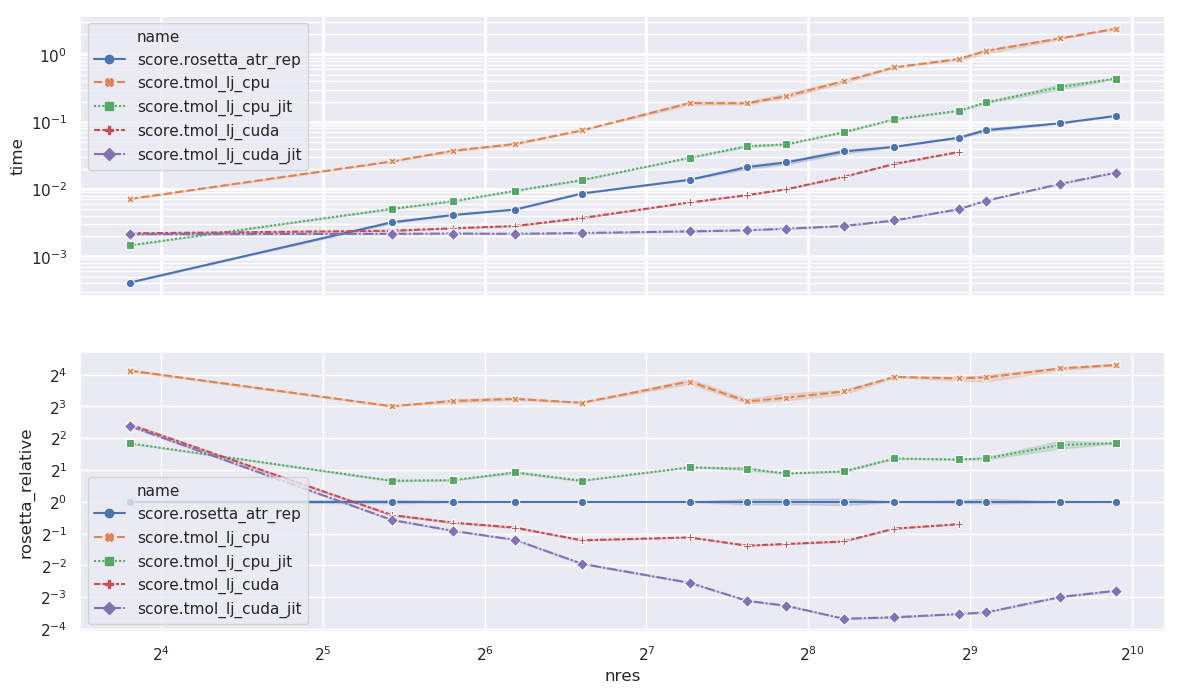

In [17]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="name", style="name", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "rosetta_relative", data=dat, hue="name", style="name", markers=True)

In [18]:
(
    dat.query("name=='score.tmol_lj_cuda_jit'")
    .groupby("nres")[["rosetta_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
)

mean                        max                        std  \
     rosetta_relative      time rosetta_relative      time rosetta_relative   
nres                                                                          
14           5.217196  0.002125         7.460818  0.003038         0.207938   
43           0.674045  0.002160         1.176191  0.003769         0.045436   
56           0.529446  0.002182         0.662099  0.002729         0.017853   
73           0.435372  0.002161         0.914441  0.004540         0.048570   
97           0.258836  0.002220         0.547887  0.004700         0.028854   
154          0.170855  0.002349         0.381256  0.005241         0.011329   
197          0.115268  0.002440         0.129136  0.002733         0.002295   
233          0.103533  0.002575         0.237915  0.005917         0.010627   
298          0.078004  0.002820         0.086519  0.003128         0.001140   
370          0.080605  0.003413         0.133110  0.005636         0.006577   
488          0.086569  0.005023         0.127582  0.007402         0.003512   
548          0.089509  0.006717         0.116730  0.008760         0.003691   
753          0.125380  0.011921         0.140906  0.013397         0.003689   
956          0.143785  0.017584         0.203962  0.024944         0.009584   

                
          time  
nres            
14    0.000085  
43    0.000146  
56    0.000074  
73    0.000241  
97    0.000248  
154   0.000156  
197   0.000049  
233   0.000264  
298   0.000041  
370   0.000278  
488   0.000204  
548   0.000277  
753   0.000351  
956   0.001172